# RAG over complex PDF


## Setting
 - Auto Reload
 - path for utils

In [190]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Bedrock Client 생성

In [192]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [193]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [194]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [195]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f8ebc187850>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f8ebc184e80>])

### Embedding 모델 선택

In [196]:
from langchain.embeddings import BedrockEmbeddings

In [197]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [198]:
import boto3
from utils.ssm import parameter_store

In [199]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [200]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [201]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [202]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [203]:
from utils.opensearch import opensearch_utils

In [204]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [205]:
from utils.rag import qa_chain_complex_pdf
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [206]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [207]:
system_prompt = prompt_repo.get_system_prompt()

In [208]:
qa = qa_chain_complex_pdf(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    get_context=True,
    verbose=False
)

In [209]:
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "만기가격이 기준가격의 80% 일 때 만기상환금액 계산하는 방법 알려줘"
query = "수익률 그래프 설명해줘"
#query = "생산직 근로자를 위한 정기 안전보건교육은 분기마다 몇시간 이상 진행하나요?"
#query = "사용금지 표지의 용도는?"
query = "산업용 로봇의 방호장치는?"
query = "안전검사 처리절차는?"
query = "산업안전보건법 과태료 부과는 언제부터?"
# query = "보존기간이 3년인 산업재해 발생 서류 중 3일이상 휴업재해가 발생하면, 어떤 서류를 보존해야 하나요?"

# query = "사업장 감독시 요구서류 목록은?"
# query = "산업안전보건법에서 중대재해를 어떻게 정의하나요?"
# query = "산업안전보건법의 특징은?"

response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

산업안전보건법에 따른 과태료 부과 시기는 다음과 같이 규정되어 있습니다.

"과태료는 고용노동부장관(지방고용노동관서장)이 부과･징수하며, 과태료를 부과하는 때에는 당해 위반행위를 조사･확인한 후 위반사실과 과태료 금액 등을 서면으로 명시하여 이를 납부할 것을 과태료 처분대상자에게 통지하게 된다."

따라서 산업안전보건법 위반 시 고용노동부에서 해당 위반사실을 조사, 확인한 후에 과태료를 부과하게 됩니다. 위반행위 발견 시점부터 조사 후 과태료 통지까지의 기간이 소요되므로, 위반행위 즉시 과태료가 부과되는 것은 아닙니다.-----------------------------------------------
1. Category: CompositeElement, Chunk: 409 Characters
-----------------------------------------------
(17) 산업안전보건법 위반시 과태료 즉시 부과 지방고용노동관서에서 사업장 감독시 산업재해발생 미보고, 근로자 안전보건교육 미실시 등 법 위반시 사업주에게 과태료를 즉시 부과하고
근로자도 안전모 미착용 등 법위반시 과 태료가 부과 된다. (산업안전보건법 제72조, 위반내용에 따라 300∼1,000만원 이하의 과태료 부과) ■ 과태료 부과 대상 ○
산업안전보건법은 대부분 사업주를 의무주체로 규정하고 있어, 원칙적으로 실제 위 반행위자와 관계없이 당해 사업주가 과태료 부과대상이 된다. ■ 과태료 부과 절차 ○ 과태료는
고용노동부장관(지방고용노동관서장)이 부과･징수하며, 과태료를 부과하 는 때에는 당해 위반행위를 조사･확인한 후 위반사실과 과태료 금액 등을 서면으로 명시하여 이를 납부할 것을
과태료 처분대상자에게 통지하게 된다.
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'],
'last_modified': '2024-03-15T07:48:53', '

### Parameter updates

In [210]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [236]:
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "만기가격이 기준가격의 80% 일 때 만기상환금액 계산하는 방법 알려줘"
#query = "수익률 그래프 설명해줘"
#query = "기초자산가격의 100% 일 때, 세전 수익률 알려줘"
#query = "이 이미지는 공단 실사 및 지방 노동관서 업무 절차를 보여주는 흐름도"
query = "작업환경측정 절차를 알려줘"
query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?"
query = "안전보건표지에서 지시표지의 종류는?"


response, contexts = qa.invoke(
    query = query
)

이미지에서 볼 수 있는 지시표지의 종류는 보안경 착용, 방독마스크 착용, 방진마스크 착용, 보안면 착용, 안전모 착용, 귀마개 착용, 안전화 착용, 안전장갑 착용, 안전복 착용입니다. 이러한 지시표지는 작업장에서 작업자가 반드시 해당 보호구를 착용하고 출입해야 함을 알려주는 역할을 합니다.

##################################
query:  안전보건표지에서 지시표지의 종류는?
##################################


### Answer ###
이미지에서 볼 수 있는 지시표지의 종류는 보안경 착용, 방독마스크 착용, 방진마스크 착용, 보안면 착용, 안전모 착용, 귀마개 착용, 안전화 착용, 안전장갑 착용, 안전복
착용입니다. 이러한 지시표지는 작업장에서 작업자가 반드시 해당 보호구를 착용하고 출입해야 함을 알려주는 역할을 합니다.


### Contexts ###
-----------------------------------------------
1. Category: CompositeElement, Chunk: 34 Characters
-----------------------------------------------
96 제3장 산업안전보건법 일반 ■ 안전보건표지의 종류와 형태
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'],
'last_modified': '2024-03-15T07:48:53', 'page_number': 8, 'file_directory': './data/complex_pdf',
'filename': 'text2.pdf', 'category': 'CompositeElement', 'id':
'2c0c94d5-3645-413b-8fd8-619f298daf0a'}
-----------------------------------------------
2. Category: Table, Chunk: 184 Characters
-----------------------------------------------
이 표는 안전표지의 종류와 용도, 사용장소를 분류하여 보여주고 있습니다. 금지, 경고, 지시, 안내 표지들과 그에 따른 상황별 금지,

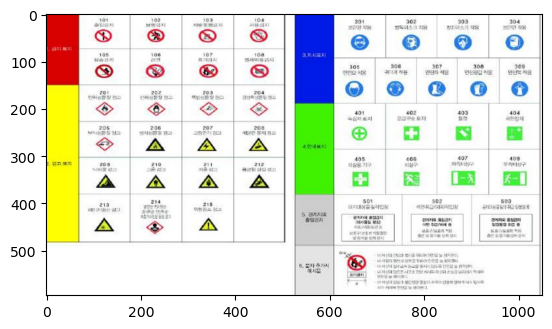

이 이미지는 안전 표지판과 관련된 다양한 기호와 픽토그램을 보여주고 있습니다. 빨간색, 노란색, 파란색, 녹색 등 여러 가지 색상으로 구분되어 있으며, 금지 표시, 경고 표시,
행동 지시 표시 등을 포함하고 있습니다. 이러한 안전 기호는 화재, 유해 물질, 긴급 상황 등 다양한 위험 상황에서 안전을 위해 사용됩니다. 전체적으로 안전과 관련된 중요한 정보를
시각적으로 전달하는 데 목적이 있습니다.
metadata:
 {'img_path': './fig/figure-31-56.jpg', 'category': 'Image', 'image_base64': '', 'id':
'ad44f8b3-eadc-4c9b-a477-8648efc45f21', 'origin_image': ''}
-----------------------------------------------
6. Category: Table, Chunk: 199 Characters
-----------------------------------------------
이 표는 작업장에서 착용해야 하는 개인보호구, 안전시설, 위험표지판 등을 나열하고 있습니다. 방진마스크, 보안면, 안전모, 귀마개, 안전화, 안전장갑, 방열복 등의 착용 장소와
응급구호설비, 세안장치, 비상용기구, 비상구 표지 장소, 유해물질 및 석면 취급 장소 등이 포함되어 있습니다. 이는 작업자의 안전과 건강을 보호하기 위한 중요한 정보를 제공합니다.
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'detection_class_prob': 0.8090896606445312,
'coordinates': {'points': [[299.0445556640625, 735.0321044921875], [299.0445556640625,
1944.584716796875], [1373.557373046875, 1944.584716796875], [1373.557373046875, 735.0321044921875

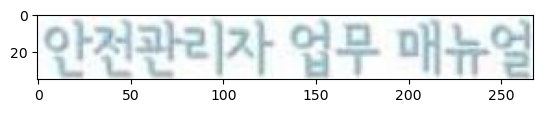

주어진 이미지는 한글 문구 "안전관리자 업무 매뉴얼"이 적혀있는 표지 또는 타이틀 페이지로 보입니다. 이는 아마도 안전 관리와 관련된 직무 지침서나 교육 자료의 일부일 것
같습니다.
metadata:
 {'img_path': './fig/figure-14-34.jpg', 'category': 'Image', 'image_base64': '', 'id':
'a163cbce-c06b-4a7d-8337-b6eed7d6fb2c', 'origin_image': ''}
-----------------------------------------------
8. Category: Table, Chunk: 165 Characters
-----------------------------------------------
이 표는 사업주가 화학물질을 취급하는 근로자의 안전과 보건을 위해 교육해야 할 내용을 설명하고 있습니다. 교육 내용에는 대상 화학물질의 명칭, 물리적 위험성과 건강 유해성, 취급
시 주의사항, 적절한 보호구 착용, 응급조치 및 사고 대처법, MSDS와 경고표지 이해 방법 등이 포함되어야 합니다.
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'detection_class_prob': 0.9142391085624695,
'coordinates': {'points': [[292.7109680175781, 1330.1220703125], [292.7109680175781,
1954.9261474609375], [1358.4066162109375, 1954.9261474609375], [1358.4066162109375,
1330.1220703125]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339},
'last_modified': '2024-03-15T07:48:53', 'filetype': 'application/pdf', 'languages

In [237]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)